# Import Libraries

#### Modeling and Modeling Metrics Libraries 

In [7]:
# Models and Transformers
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression

# Model Metrics
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, f1_score
from sklearn import metrics

# Optimization
from sklearn.model_selection import GridSearchCV

#### Data Visualization

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#### File Management

In [9]:
import os
import subprocess
import glob

import json
import csv

#### NLP & Text Parsing

In [10]:
import re
from textblob import TextBlob

#### Pandas/NumPy/Datetime

In [11]:
import pandas as pd
import numpy as np

from datetime import datetime, date, time

#### Twitter/Stock Data Scraper

In [12]:
import snscrape.modules.twitter as sntwitter
import yfinance as yf

# Custom Functions

In [13]:
# Get Twitter Data (Saved as csv on local machine)

def scrapeTweets(start_date, end_date, keyword, directory_name, tweet_limit=1):
    if not os.path.exists(directory_name): # Creates directory in current directory if doesn't already exist
        os.mkdir(directory_name)
    
    file_path = os.path.join(directory_name, f'keyword:{keyword}__start:{start_date}_end:{end_date}__limit:{tweet_limit}.csv')
    
    tweet_list = []
    for i,tweet in enumerate(sntwitter.TwitterSearchScraper(f'{keyword} since:{start_date} until:{end_date}').get_items()):
        if i > tweet_limit:
            break
        tweet_list.append([tweet.date, # Appending all tweet data into a list of list
                           tweet.id, 
                           tweet.content, 
                           tweet.user.username, 
                           tweet.user.followersCount, 
                           tweet.hashtags, 
                           tweet.cashtags, 
                           tweet.lang])
    
    df_tweets = pd.DataFrame(tweet_list, columns=['Datetime', # Creating df of tweet data
                                                  'Tweet Id', 
                                                  'Text', 
                                                  'Username', 
                                                  'Followers Count', 
                                                  'Hashtags', 
                                                  'Cashtags', 
                                                  'Language'])
    
    df_tweets.to_csv(file_path, index=False) # Writing df_tweets into new csv file
    
    if os.path.isfile(file_path) == True:
        return print(f'Successfully saved DataFrame to {file_path}')
    else:
        return print('DataFrame not saved -- possible error has occurred.')        

In [14]:
# Wrangle Tweet Data

def dataWrangle(dataframe_list):   
    df_concat = pd.concat(dataframe_list) # Concatenate all the DataFrames from the list of DataFrames
    df_filter = df_concat[df_concat['Language'] == 'en'][['Datetime', # Filter via Language = 'en'
                                                           'Tweet Id', # Remove unwanted columns
                                                           'Text', 
                                                           'Username',
                                                           'Followers Count']] 
    df_clean = df_filter.astype({'Tweet Id':str})\
                        .dropna()\
                        .drop_duplicates()\
                        .reset_index(drop=True)
    
    df_clean['Text'] = (df_clean['Text'] # Cleans out redundant string characters within each tweet
                       .apply(lambda x: ' '.join(re.sub(r'https\S+', '', x)
                                                .replace('\n', ' ')
                                                .split()
                                                )
                             )
                       )
    
    df_clean['Datetime'] = pd.to_datetime(df_clean['Datetime']).dt.floor('d').dt.tz_localize(tz=None)
    
    return df_clean.set_index('Datetime').sort_index()
                                               

In [15]:
# Get Stock Data (DataFrame)

def getStockData(ticker, start, end):
    df_stock = yf.download(ticker, start, end)
    df_stock.index = df_stock.index.tz_localize(tz=None).rename(name='Datetime')
    df_stock['Closing Differences'] = df_stock['Adj Close'].diff()
    df_stock['C-O/O'] = ((df_stock['Close']-df_stock['Open'])/df_stock['Open'])*100
    
    return df_stock    

In [16]:
# CLASSIFICATION Model Evaluation

def model_evaluation(model, X, y_true, positive_label):
    y_pred = model.predict(X)
    scores = {}
    scores['accuracy'] = round(metrics.accuracy_score(y_true, y_pred), 4)
    scores['precision'] = round(metrics.precision_score(y_true, y_pred, pos_label=positive_label), 4)
    scores['recall'] = round(metrics.recall_score(y_true, y_pred, pos_label=positive_label), 4)
    probs = model.predict_proba(X).T[1]
    precisions, recalls, thresholds = metrics.precision_recall_curve(y_true, probs, pos_label=positive_label)
    scores['area under precision-recall curve'] = round(metrics.auc(recalls, precisions), 4)
    scores['f1 score'] = round(f1_score(y_true=y_true, y_pred=y_pred, pos_label= "Positive_Trend"), 4)
    return scores

def print_model_evaluation(model_name, scores):
#     print('{} evaluation \n'.format(model_name))
    for metric, score in scores.items():
        print('Test {}: {}'.format(metric, score))


In [75]:
# 1. Polarity Score Categories as a column on DataFrame
# 2. Creating categorical polarity column

def polarityCategories(tup):
    if tup[0] < -0.05:
        return 'Negative'
    elif tup[0] > 0.05:
        return 'Positive'
    else:
        return 'Neutral'
    
def polarityColumns(df_tweets):
    df_tweets['Polarity/Subjectivity Scores'] = df_tweets['Text'].apply(lambda text: TextBlob(text).sentiment)
    df_tweets_filtered = df_tweets[df_tweets['Polarity/Subjectivity Scores'] != (0.0,0.0)]
    df_tweets_filtered = df_tweets_filtered.copy()
    df_tweets_filtered['Polarity Categories'] = df_tweets_filtered['Polarity/Subjectivity Scores'].apply(lambda x: polarityCategories(x))
    
    print(df_tweets_filtered.value_counts('Polarity Categories'))
    
    return df_tweets_filtered

# Twitter Data

## GME Tweets

In [ ]:
start_time = date(2021, 1, 8).strftime('%Y-%m-%d')
stop_time = date(2021, 2, 12).strftime('%Y-%m-%d')

In [39]:
# List of file names

# Files from two directories -- scraped at different time irl 
# for the same dates within the data

file_path_tweets_GME = glob.glob('tweets_GME/*')
file_path_tweets_scraped = glob.glob('tweets_scraped/*')

In [40]:
# Creating a list of DataFrames using glob's list of files names
df_tweet_gme_list = []
for i in file_path_tweets_GME + file_path_tweets_scraped:
    df_tweet_gme_list.append(pd.read_csv(i))

In [82]:
df_tweet_gme = dataWrangle(df_tweet_gme_list)

In [83]:
df_tweet_gme

,Tweet Id,Text,Username,Followers Count
Datetime,,,,
2021-01-08,1347684080905814016,$GME NEW ARTICLE : GameStop Is Caught in a Vic...,StckPro,4198
2021-01-08,1347601307595665408,@LondonI67782602 Volume is up today as well,gh0st_GME,2004
2021-01-08,1347604200612573184,2 pairs to be exact,KingC_GME,1125
2021-01-08,1347604783113383943,@Thebandit11417 I love it!! So stoked for you!...,gh0st_GME,2004
2021-01-08,1347606361618702337,@Daytrad58409800 Bought more $Gme,JDR1024,396
...,...,...,...,...
2021-02-11,1359666802213715971,All #RedditArmy #investors Lets bring $SNDL to...,Ban_Robinhood,222
2021-02-11,1359666659968094209,👏 Let’s SPIN the #Webull Wheel 🌟 1000 SHARES O...,PaniniDream,21
2021-02-11,1359666341943386113,All #RedditArmy #investors Lets bring $SNDL to...,Ban_Robinhood,222


# Polarity Scores

A list of goals to accomplish: \
    - Figure out polarity/subjectivity scores for every tweet\
    - For now we want to work with dates from 01/21/2021 and onwards as a test\
    - Mess about with distribution of negative/positive/neutral scores to have a healthy balance of samples\
    - Break everything up by days\
    - Move onto bringing in financial data

In [84]:
df_tweet_gme = polarityColumns(df_tweet_gme)

Polarity Categories
Positive    40804
Negative    18058
Neutral     15989
dtype: int64


In [85]:
df_tweet_gme

,Tweet Id,Text,Username,Followers Count,Polarity/Subjectivity Scores,Polarity Categories
Datetime,,,,,,
2021-01-08,1347684080905814016,$GME NEW ARTICLE : GameStop Is Caught in a Vic...,StckPro,4198,"(-0.09090909090909091, 0.6886363636363636)",Negative
2021-01-08,1347604200612573184,2 pairs to be exact,KingC_GME,1125,"(0.25, 0.25)",Positive
2021-01-08,1347604783113383943,@Thebandit11417 I love it!! So stoked for you!...,gh0st_GME,2004,"(0.75, 0.8)",Positive
2021-01-08,1347606361618702337,@Daytrad58409800 Bought more $Gme,JDR1024,396,"(0.5, 0.5)",Positive
2021-01-08,1347606659766644744,@alphaverve Long $GME.,JDR1024,396,"(-0.05, 0.4)",Neutral
...,...,...,...,...,...,...
2021-02-11,1359666976965222402,"@Shav457 Hey, Shav! I wanted to get into inves...",ashfakuztweets,95,"(0.0, 0.25)",Neutral
2021-02-11,1359666863156920320,@Investingcom I hope @TheRoaringKitty will be ...,bleachain,36,"(0.5, 0.5)",Positive
2021-02-11,1359666802213715971,All #RedditArmy #investors Lets bring $SNDL to...,Ban_Robinhood,222,"(-0.16666666666666666, 0.44166666666666665)",Negative


# Stock Data

## GME

In [86]:
df_stock_gme = getStockData('GME','2021-01-21','2021-02-12')

[*********************100%***********************]  1 of 1 completed


In [88]:
df_stock_gme

,Open,High,Low,Close,Adj Close,Volume,Closing Differences,C-O/O
Datetime,,,,,,,,
2021-01-21,39.230000,44.750000,37.000000,43.029999,43.029999,56216900,NaN,9.686463
2021-01-22,42.590000,76.760002,42.320000,65.010002,65.010002,197157900,21.980003,52.641470
2021-01-25,96.730003,159.179993,61.130001,76.790001,76.790001,177874000,11.779999,-20.614082
2021-01-26,88.559998,150.000000,80.199997,147.979996,147.979996,178588000,71.189995,67.095754
2021-01-27,354.829987,380.000000,249.000000,347.510010,347.510010,93396700,199.530014,-2.062953
2021-01-28,265.000000,483.000000,112.250000,193.600006,193.600006,58815800,-153.910004,-26.943394
2021-01-29,379.709991,413.980011,250.000000,325.000000,325.000000,50566100,131.399994,-14.408362
2021-02-01,316.559998,322.000000,212.000000,225.000000,225.000000,37382200,-100.000000,-28.923426
2021-02-02,140.759995,158.000000,74.220001,90.000000,90.000000,78183100,-135.000000,-36.061379


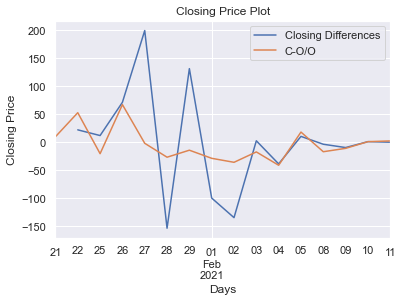

In [87]:
# Plot

df_stock_gme[['Closing Differences', 'C-O/O']].plot()

# plt.ylim(-120, 120)

plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.title('Closing Price Plot');

## AAPL

In [89]:
df_stock_aapl = getStockData('AAPL', '2021-01-01', '2021-03-01')

[*********************100%***********************]  1 of 1 completed


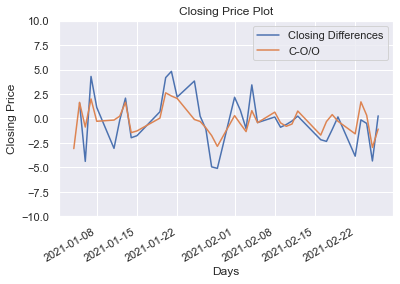

In [96]:
# Plot

df_stock_aapl[['Closing Differences', 'C-O/O']].plot()

plt.ylim(-10, 10)

plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.title('Closing Price Plot');

# Merging Twitter + Stock DataFrames

## GME

In [89]:
# Why is there NaN values for Volume and closing differences?
# Because the stock market is only opened on business days!
# So we dropped NaN values

df_merged_gme = df_stock_gme.merge(df_tweet_gme, how='right', left_index=True, right_index=True).dropna()

In [91]:
df_merged_gme['Closing Trend'] = df_merged_gme['Closing Differences'].apply(lambda x: "Positive_Trend" if x>=0 else "Negative_Trend")

## AAPL

# Dealing with Imbalances

In [33]:
from imblearn.over_sampling import SMOTE

In [35]:
sampler = SMOTE(random_state=42)

# Modeling

## GME

#### Train/Test Split

In [92]:
X = df_merged_gme
y = df_merged_gme['Closing Trend']

In [93]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Support Vector Machine (Baseline)

In [39]:
transformer_svm = ColumnTransformer([
    ('ohe', OneHotEncoder(), ['Polarity Categories']),
    ('scaler', StandardScaler(), ['Followers Count'])
])

In [42]:
pipe_svm = Pipeline([
    ('ohe', transformer_svm),
    ('svm', svm.LinearSVC())
])

In [44]:
pipe_svm_fit = pipe_svm.fit(X_train, y_train)

C:\Users\Daanish\anaconda3\envs\capstone_environment\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [45]:
pipe_svm_fit.score(X_test, y_test)

0.5198527057316683

#### Random Forest Classifier (Baseline)

In [94]:
transformer_rfc = ColumnTransformer([
    ('ohe', OneHotEncoder(), ['Polarity Categories']),
    ('scaler', StandardScaler(), ['Followers Count'])
])

In [95]:
pipe_rfc = Pipeline([
    ('ohe', transformer_rfc),
    ('randomforest', GridSearchCV(RandomForestClassifier(),
                                  param_grid={},
                                  verbose=3,
                                  n_jobs=4))
])

In [100]:
pipe_rfc_fit = pipe_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [101]:
print_model_evaluation(pipe_rfc_fit, model_evaluation(pipe_rfc_fit, X_test, y_test, positive_label='Positive_Trend'))

Test accuracy: 0.5854
Test precision: 0.576
Test recall: 0.5208
Test area under precision-recall curve: 0.5957
Test f1 score: 0.547


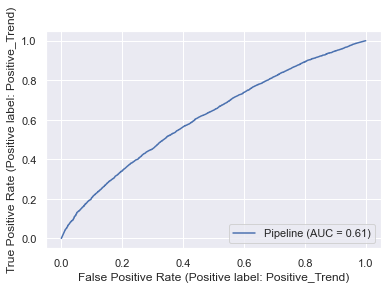

In [105]:
RocCurveDisplay.from_estimator(pipe_rfc_fit, X_test, y_test)

#### Logistic Regression (Baseline)

In [65]:
transformer_logit = ColumnTransformer([
    ('ohe', OneHotEncoder(), ['Polarity Categories']),
    ('scaler', StandardScaler(), ['Followers Count'])
])

In [66]:
pipe_logit = Pipeline([
    ('ohe', transformer_logit),
    ('logit', LogisticRegression())
])

In [69]:
model_evaluation(pipe_logit, X_test, y_test, positive_label='Positive_Trend')

{'accuracy': 0.5199,
 'precision': 0.5422,
 'recall': 0.0075,
 'area under precision-recall curve': 0.4891,
 'f1 score': 0.0148}